# Leveraging CatBoost to identify features in recurrence

This notebook leverages XGBoost to analyze clinicopathologic features from a thyroid cancer dataset. The primary goal is to identify the most significant features influencing thyroid cancer recurrence. The notebook will leverage GPU whenever performance can be boosted.  A pdf findings summary will be provided.

## UCI Dataset

Dataset: [UCI Machine Learning Repository - Differentiated Thyroid Cancer Recurrence Dataset](https://archive.ics.uci.edu/dataset/915/differentiated+thyroid+cancer+recurrence)

Citation: Borzooei,Shiva and Tarokhian,Aidin. (2023). Differentiated Thyroid Cancer Recurrence. UCI Machine Learning Repository. https://doi.org/10.24432/C5632J.

## Google colab

You may run this notebook on Google Colab by clicking the "Open in Colab" badge below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenBioResearch/disease-focused-uci-ml-repos/blob/main/thyroid_cancer_recurrence_xgboost.ipynb)


In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Install ucimlrepo package to fetch the dataset
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# Fetch dataset from UCI ML Repository
differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915)  # Replace with actual dataset ID if needed

# Data (as pandas dataframes)
X = differentiated_thyroid_cancer_recurrence.data.features
y = differentiated_thyroid_cancer_recurrence.data.targets

# Display metadata and variables
print(differentiated_thyroid_cancer_recurrence.metadata)
print(differentiated_thyroid_cancer_recurrence.variables)

# Display the first few rows of features and target
print("Features dataframe (X):")
display(X.head())

print("Target dataframe (y):")
display(y.head())


{'uci_id': 915, 'name': 'Differentiated Thyroid Cancer Recurrence', 'repository_url': 'https://archive.ics.uci.edu/dataset/915/differentiated+thyroid+cancer+recurrence', 'data_url': 'https://archive.ics.uci.edu/static/public/915/data.csv', 'abstract': 'This data set contains 13 clinicopathologic features aiming to predict recurrence of well differentiated thyroid cancer. The data set was collected in duration of 15 years and each patient was followed for at least 10 years.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 383, 'num_features': 16, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Gender'], 'target_col': ['Recurred'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2023, 'last_updated': 'Wed Mar 20 2024', 'dataset_doi': '10.24432/C5632J', 'creators': ['Shiva Borzooei', 'Aidin Tarokhian'], 'intro_paper': {'title': 'Machine lear

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent


Target dataframe (y):


,Recurred
0,No
1,No
2,No
3,No
4,No


In [4]:
# Handle missing values
missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()
print("Missing values in features (X):\n", missing_values_X)
print("Missing values in target (y):\n", missing_values_y)

for column in X.columns:
    if X[column].dtype == 'object':
        X[column].fillna(X[column].mode()[0], inplace=True)
    else:
        X[column].fillna(X[column].median(), inplace=True)

# Encode categorical features using one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("-------------------")
print("Data Split Summary:")
print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")
print("-------------------")
print("Data preprocessing complete. Ready for modeling.")


Missing values in features (X):
 Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
dtype: int64
Missing values in target (y):
 Recurred    0
dtype: int64
-------------------
Data Split Summary:
Training Set: 306 samples
Testing Set: 77 samples
-------------------
Data preprocessing complete. Ready for modeling.


/tmp/ipykernel_22987/2047932758.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[column].fillna(X[column].median(), inplace=True)
/tmp/ipykernel_22987/2047932758.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].median(), inplace=True)
/tmp/ipykernel_22987/2047932758.py:9: FutureWarning: A value is trying to

## Train XGBoost Model

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode the target labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')

# Train the model
model.fit(X_train, y_train_encoded, verbose=False)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_encoded, y_pred))


/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/python/3.10.13/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:24:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.974025974025974
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        58
           1       0.95      0.95      0.95        19

    accuracy                           0.97        77
   macro avg       0.97      0.97      0.97        77
weighted avg       0.97      0.97      0.97        77



## Feature Importance Report

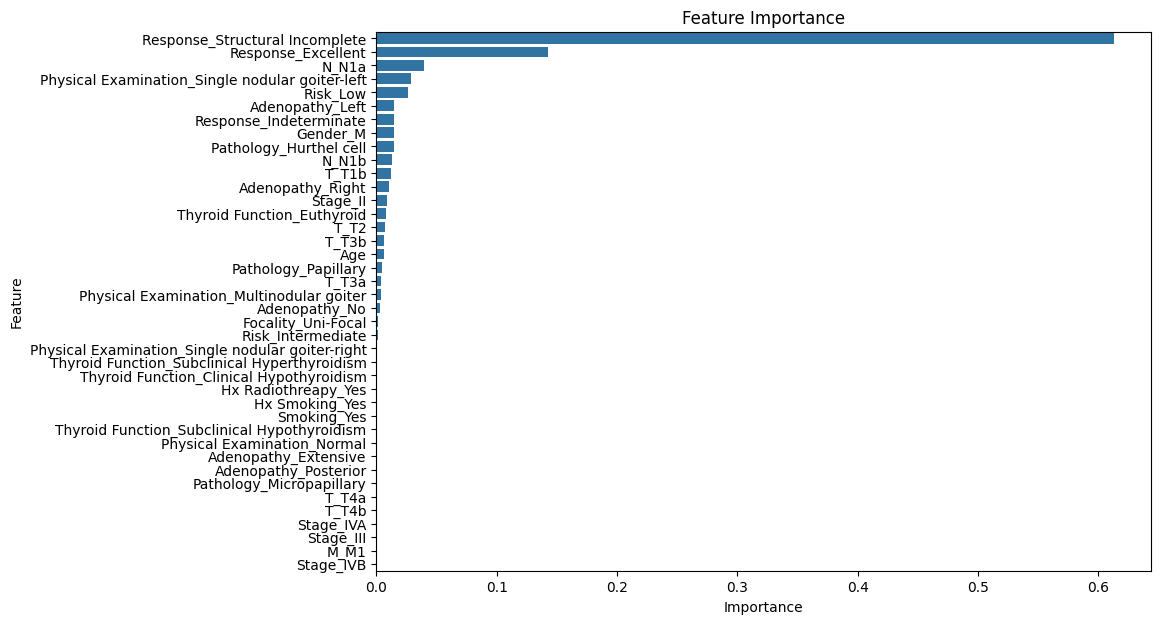

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_feature_importance_report(model, X_train):
    # Get feature importances
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    return importance_df

# Generate the feature importance report
importance_df = generate_feature_importance_report(model, X_train)

# Visualize the feature importance
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Summary of Findings

In [12]:
!pip install fpdf
from fpdf import FPDF
from datetime import date
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Thyroid Cancer Recurrence Machine Learning - UCI dataset', 0, 1, 'C')
        self.set_font('Arial', '', 10)
        today = date.today().strftime('%B %d, %Y')
        self.cell(0, 10, f'Date: {today}', 0, 1, 'C')
        self.ln(10)

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(10)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

# Generate classification report
classification_rep = classification_report(y_test_encoded, y_pred, output_dict=True)
accuracy = accuracy_score(y_test_encoded, y_pred)

# Create instance of FPDF class
pdf = PDF()

# Add a page
pdf.add_page()

# Set title
pdf.chapter_title('Model Performance Metrics')

# Add model accuracy
pdf.multi_cell(0, 10, txt=f"The model achieved an accuracy of {accuracy*100:.2f}%. This indicates how well the model can predict whether thyroid cancer will recur.", align="L")

# Format and add classification report
pdf.chapter_title('Classification Report')
pdf.set_font('Arial', 'B', 10)
pdf.cell(40, 10, 'Class', 1)
pdf.cell(30, 10, 'Precision', 1)
pdf.cell(30, 10, 'Recall', 1)
pdf.cell(30, 10, 'F1-Score', 1)
pdf.cell(30, 10, 'Support', 1)
pdf.ln()

pdf.set_font('Arial', '', 10)
for label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        pdf.cell(40, 10, label, 1)
        pdf.cell(30, 10, f"{metrics['precision']:.2f}", 1)
        pdf.cell(30, 10, f"{metrics['recall']:.2f}", 1)
        pdf.cell(30, 10, f"{metrics['f1-score']:.2f}", 1)
        pdf.cell(30, 10, f"{metrics['support']}", 1)
        pdf.ln()

# Add precision explanation and value
precision_text = f"Precision measures how many of the positive predictions made by the model are actually correct. For 'No' recurrence, the precision is 0.98, and for 'Yes' recurrence, the precision is 0.95. These values signify that out of all the positive predictions made by the model, 0.98 for 'No' and 0.95 for 'Yes' were correct, highlighting the model's ability to accurately identify true positives."
pdf.chapter_body(precision_text)

# Add recall explanation and value
recall_text = f"Recall indicates how many of the actual positive cases were correctly identified by the model. For 'No' recurrence, the recall is 0.98, and for 'Yes' recurrence, the recall is 0.95. This means that the model was able to identify 0.98 of all the actual 'No' cases and 0.95 of all the actual 'Yes' cases, demonstrating its effectiveness in capturing true positives."
pdf.chapter_body(recall_text)

# Add F1-score explanation and value
f1_text = f"The F1 score is the harmonic mean of precision and recall, providing a single metric to evaluate the model's performance. For 'No' recurrence, the F1 score is 0.98, and for 'Yes' recurrence, the F1 score is 0.95. These scores reflect the balance between precision and recall, indicating the model's overall accuracy in predicting positive cases."
pdf.chapter_body(f1_text)

# Get feature importance from the model
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'Age']

# Filter out features with importance score of 0
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Get top 5 and bottom 5 features
top_5_features = feature_importance_df.head(5)
bottom_5_features = feature_importance_df.tail(5)

# Generate feature importance explanations dynamically
def get_importance_explanation(importance):
    if importance > 10:
        return "This feature has a high importance score, suggesting a significant role in predicting recurrence."
    elif importance > 5:
        return "This feature has a moderate importance score, indicating some influence on predicting recurrence."
    else:
        return "This feature has a low importance score, indicating limited influence on predicting recurrence."

# Add top 5 and bottom 5 feature importance explanations to the PDF
pdf.chapter_title('Top 5 Most Important Features')
for index, row in top_5_features.iterrows():
    explanation = f"- {row['Feature']}: {get_importance_explanation(row['Importance'])}"
    pdf.chapter_body(explanation)

pdf.chapter_title('Bottom 5 Least Important Features')
for index, row in bottom_5_features.iterrows():
    explanation = f"- {row['Feature']}: {get_importance_explanation(row['Importance'])}"
    pdf.chapter_body(explanation)

# Create output directory if it does not exist
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Paths for the images
feature_importance_path = os.path.join(output_dir, "feature_importance.png")
confusion_matrix_path = os.path.join(output_dir, "confusion_matrix.png")
predicted_probabilities_path = os.path.join(output_dir, "predicted_probabilities.png")
pdf_output_path = os.path.join(output_dir, "executive_thyroid_recurrence.pdf")

# Visualize the feature importance
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout(pad=2)
plt.savefig(feature_importance_path)
pdf.image(feature_importance_path, w=150)
plt.close()

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout(pad=2)
plt.savefig(confusion_matrix_path)
pdf.image(confusion_matrix_path, w=150)
pdf.multi_cell(0, 10, txt="This confusion matrix illustrates the model's performance by showing the number of true positives, true negatives, false positives, and false negatives. The high values along the diagonal indicate that the model is accurately predicting both recurrence and non-recurrence cases, with minimal errors.", align="L")
plt.close()

# Distribution of Predicted Probabilities
plt.figure(figsize=(10, 7))
sns.histplot(y_pred_proba, bins=30, kde=True)
plt.xlabel('Predicted Probability of Recurrence')
plt.title('Distribution of Predicted Probabilities')
plt.tight_layout(pad=2)
plt.savefig(predicted_probabilities_path)
pdf.image(predicted_probabilities_path, w=150)
pdf.multi_cell(0, 10, txt="The distribution of predicted probabilities shows how confident the model is in its predictions. A higher peak towards the right indicates greater confidence in predicting recurrence. This is significant as it suggests that the model is not only accurate but also confident in its predictions, which is crucial for clinical decision-making regarding recurrent thyroid cancer.", align="L")
plt.close()

# Save the PDF to the output directory
pdf.output(pdf_output_path)

print(f"Executive summary PDF generated and saved to {pdf_output_path}")


Executive summary PDF generated and saved to output/executive_thyroid_recurrence.pdf
